# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [ ]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.6 MB/s eta 0:00:00


Check the installation by running the following cell

In [ ]:
import monai
monai.config.print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

In [ ]:
!unzip /content/TNBC_NucleiSegmentation.zip

Archive:  /content/TNBC_NucleiSegmentation.zip
   creating: TNBC_NucleiSegmentation/
   creating: TNBC_NucleiSegmentation/GT_01/
  inflating: TNBC_NucleiSegmentation/GT_01/01_1.png  
   creating: __MACOSX/
   creating: __MACOSX/TNBC_NucleiSegmentation/
   creating: __MACOSX/TNBC_NucleiSegmentation/GT_01/
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_1.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_2.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_2.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_3.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_3.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_4.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_4.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_5.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_5.png  
  inflating: TNBC_NucleiSegmentation/GT_01/01_6.png  
  inflating: __MACOSX/TNBC_NucleiSegmentation/GT_01/._01_6.png  
  inflating: TNBC_NucleiSegmentati

In [ ]:
!ls TNBC_NucleiSegmentation

GT_01  GT_03  GT_05  GT_07  GT_09  GT_11     Slide_02  Slide_04  Slide_06  Slide_08  Slide_10
GT_02  GT_04  GT_06  GT_08  GT_10  Slide_01  Slide_03  Slide_05  Slide_07  Slide_09  Slide_11


## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [ ]:
import torch

from monai.transforms import Compose, LoadImage, ToTensor, NormalizeIntensity, EnsureChannelFirst # AsChannelFirst, AddChannel
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [ ]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(label_files[index])



By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [ ]:
import os

image_files = []
label_files = []

data_dir = '/content/TNBC_NucleiSegmentation'

for root, dirs, files in os.walk(data_dir):
  for file in files:
    if file.endswith(".png"):
      if "GT" in root:
        label_files.append(os.path.join(root, file))
      elif "Slide" in root:
        image_files.append(os.path.join(root, file))

train_image_files = image_files[:int(0.8 * len(image_files))]
train_label_files = label_files[:int(0.8 * len(label_files))]
test_image_files = image_files[int(0.8 * len(image_files)):]
test_label_files = label_files[int(0.8 * len(label_files)):]


train_ds = CellDataset(train_image_files, train_label_files, image_trans, label_trans)
test_ds = CellDataset(test_image_files, test_label_files, image_trans, label_trans)

print(f"Train dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")


image, label = train_ds[0]
print(image.shape)  # Check the shape of the image
print(label.shape)  # Check the shape of the label


Train dataset size: 40
Test dataset size: 10
torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [ ]:
train_dataset = CellDataset(train_image_files, train_label_files, image_trans, label_trans)
test_dataset = CellDataset(test_image_files, test_label_files, image_trans, label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [ ]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

torch.Size([1, 3, 512, 512])

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [ ]:
from monai.networks.nets import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(4, 8, 16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
)

ValueError: the length of `strides` should equal to `len(channels) - 1`.

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [ ]:
from monai.losses import DiceLoss

loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser



In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [ ]:
epoch_loss_values = list()
for epoch in range(50):

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function
        loss.backward()

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


1/40, train_loss: 0.3627
2/40, train_loss: 0.7598
3/40, train_loss: 0.2289
4/40, train_loss: 0.1757
5/40, train_loss: 0.2105
6/40, train_loss: 0.4032
7/40, train_loss: 0.2800
8/40, train_loss: 0.2939
9/40, train_loss: 0.2929
10/40, train_loss: 0.2947
11/40, train_loss: 0.1844
12/40, train_loss: 0.3421
13/40, train_loss: 0.2757
14/40, train_loss: 0.3916
15/40, train_loss: 0.1545
16/40, train_loss: 0.2780
17/40, train_loss: 0.1495
18/40, train_loss: 0.9460
19/40, train_loss: 0.1929
20/40, train_loss: 0.2191
21/40, train_loss: 0.6303
22/40, train_loss: 0.2270
23/40, train_loss: 0.3092
24/40, train_loss: 0.2813
25/40, train_loss: 0.4576
26/40, train_loss: 0.2559
27/40, train_loss: 0.2400
28/40, train_loss: 0.2352
29/40, train_loss: 0.3900
30/40, train_loss: 0.6507
31/40, train_loss: 0.2854
32/40, train_loss: 0.2806
33/40, train_loss: 0.6758
34/40, train_loss: 0.4672
35/40, train_loss: 0.2468
36/40, train_loss: 0.3478
37/40, train_loss: 0.3238
38/40, train_loss: 0.2811
39/40, train_loss: 0.

Display the prediction of your model on several image

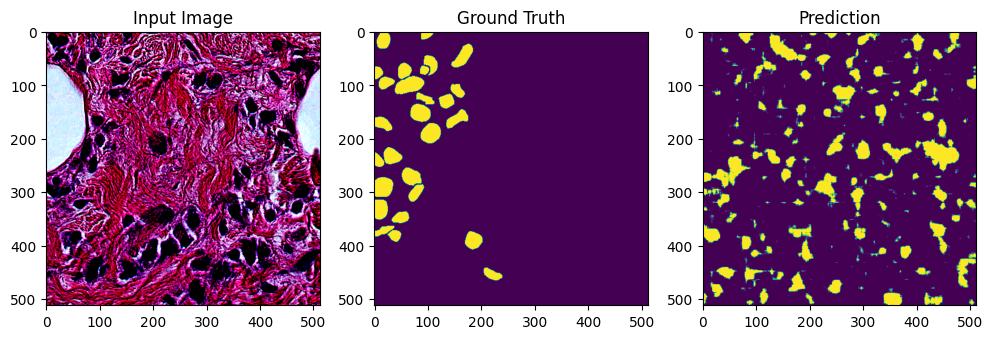

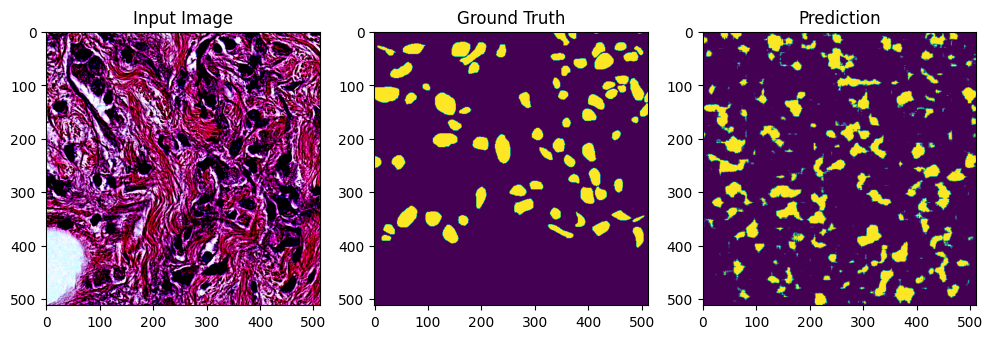

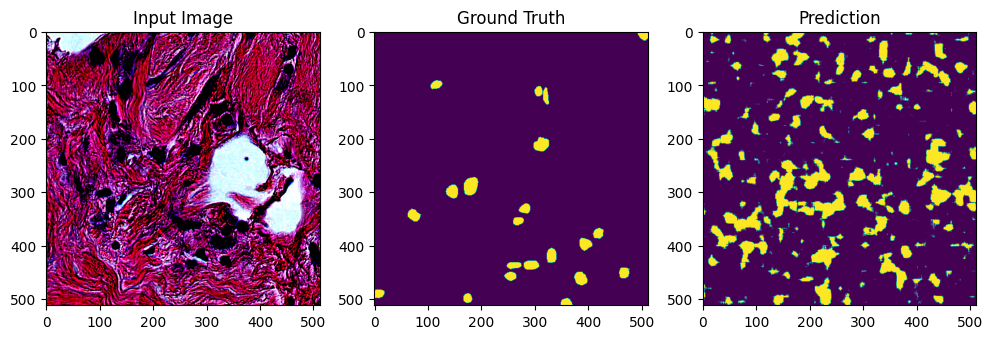

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i in range(3, 6):  # Display predictions for 3 images
        image, label = test_dataset[i]
        image = image.unsqueeze(0)  # Add batch dimension
        prediction = model(image)
        prediction = prediction.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(label.squeeze(0).cpu().numpy())
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(torch.sigmoid(prediction).cpu().numpy())  # Apply sigmoid for binary segmentation
        plt.title("Prediction")
        plt.show()

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model